In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
netflix = pd.read_csv('../data/final_data/netflix_final_data.csv')

In [3]:
ratings = pd.read_csv('../data/raw/title.ratings.tsv', sep='\t')

basics = pd.read_csv('../data/raw/title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'isAdult', 'runtimeMinutes', 'genres'])


C:\Users\Joeyz\AppData\Local\Temp\ipykernel_19968\2180540322.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  basics = pd.read_csv('../data/raw/title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'isAdult', 'runtimeMinutes', 'genres'])


In [4]:
df = netflix.merge(ratings, how='left', on='tconst').merge(basics, how='left', on='tconst', )

Let's first drop the 1 row that has no tconst, meaning it could not be found on IMDB.

In [5]:
#df.isna().sum()
df = df[df['tconst'].notna()]

In [6]:
#My Wonderful Life Manually added data

df.loc[df['title']=='my wonderful life', 'averageRating'] = 5.9
df.loc[df['title']=='my wonderful life', 'numVotes'] = 714
df.loc[df['title']=='my wonderful life', 'titleType'] = 'movie'
df.loc[df['title']=='my wonderful life', 'runtimeMinutes'] = 99
df.loc[df['title']=='my wonderful life', 'isAdult'] = 0
df.loc[df['title']=='my wonderful life', 'genres'] = 'Comedy,Drama,Romance'

Change is_top_10 into int

In [7]:
df['is_top10'] = df['is_top10'].astype(int)

replace \N with nan

In [8]:
df.replace('\\N', np.nan, inplace=True)

Split into movies and tv_shows, since I think they are too different to combine into 1 model

In [9]:
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]

## Movies

Drop columns, remove rows with >1 NaN entry

In [10]:
# drop columns that are not needed
movies = movies.drop(['tconst', 'combined_title', 'title', 'season', 'is_tv_show'], axis = 1)

# remove any rows with > 1 NaN entry
# rowWiseNullCounter = pd.DataFrame(movies.isnull().sum(axis = 1))
# indexRowsToRemove1 = list(rowWiseNullCounter[rowWiseNullCounter[0] >= 1].index.values)

# for i in indexRowsToRemove1:
#     movies.drop(index = i, axis = 1, inplace = True)

# movies = movies.reset_index(drop = True)

Now make train and test sets

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
movies_train, movies_test = train_test_split(movies, test_size=0.3, random_state=100)

In [20]:
movies_train_X = movies_train.drop(['is_top10'], axis = 1)
movies_train_Y = movies_train['is_top10']

movies_test_X = movies_test.drop(['is_top10'], axis = 1)
movies_test_Y = movies_test['is_top10']

I want to first one hot encode titleType, and turn genres into bag of words matrix.

impute the missing ratings data, then turn genres into a bag of words matrix

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
movies_test_X.isna().sum()

release_year_x     0
averageRating      2
numVotes           2
titleType          0
isAdult            0
runtimeMinutes    12
genres             0
dtype: int64

In [23]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(), 'genres')
    ],
    remainder='passthrough')

In [24]:
from sklearn.pipeline import Pipeline

In [25]:
from sklearn.feature_selection import SelectFromModel

In [59]:
#make sklearn pipeline with transform, normalization, and model
pipe = Pipeline(
    steps=[
        ('transformer', transformer),
        ('normalizer', sklearn.preprocessing.Normalizer()),
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),
        #('feature_selection', SelectFromModel(sklearn.linear_model.LogisticRegression())),
        ('logistic_regress', sklearn.linear_model.LogisticRegression(max_iter = 1000))
        
    ]
)

In [60]:
from sklearn.model_selection import GridSearchCV

In [61]:
gs = GridSearchCV(
    pipe,
    param_grid={
        #'logistic_regress__penalty': ['elasticnet'],
        'logistic_regress__C': [0.01, 0.1, 1, 10, 100],
        'logistic_regress__solver': ['lbfgs','saga'],
        #'logistic_regress__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [62]:
gs.fit(movies_train_X, movies_train_Y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
                                                                        ('bagofw',
                                                                         CountVectorizer(),
                                                                         'genres')])),
                                       ('normalizer', Normalizer()),
                                       ('standardizer',
                                        StandardScaler(with_mean=False)),
                                       ('logistic_regress',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logistic_regress__C': [0.01, 0.1, 1, 10, 100],
                         'logistic_regress__solver': ['lbfgs', 'saga']},
             refit='AUC', scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'})

In [63]:
gs.best_params_

{'logistic_regress__C': 0.01, 'logistic_regress__solver': 'lbfgs'}

In [64]:
gs.best_score_

0.7413984154462796

Try with different Classifiers

In [65]:
pipeline2 = Pipeline(
    steps=[
        ('transformer', transformer),
        ('normalizer', sklearn.preprocessing.StandardScaler(with_mean=False)),
        ('svc', sklearn.linear_model.SGDClassifier())
    ]
)

In [66]:
gs2 = GridSearchCV(
    pipeline2,
    param_grid={
        'svc__loss': ['hinge', 'modified_huber'],
        'svc__alpha': [0.01, 0.1, 1],
        #'svc__C': [0.1, 1, 10],
        #'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        #'svc__degree': [2, 3, 4, 5],
        #'svc__gamma': ['scale', 'auto'],
        #'svc__coef0': [0.0, 0.1, 0.5, 1.0],
        #'svc__shrinking': [True, False],
        #'svc__probability': [True, False],
        #'svc__tol': [0.001, 0.0001, 0.00001],
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)

In [67]:
gs2.fit(movies_train_X, movies_train_Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('imputer',
                                                                         SimpleImputer(),
                                                                         ['averageRating',
                                                                          'numVotes',
                                                                          'runtimeMinutes']),
                                                                        ('bagofw',
                                                                         CountVectorizer(),
                                                                         'genres')])),
                                       ('normalizer',
                                        StandardScaler(with_mean=False)),
                                       ('svc', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'svc__alpha': [0.01, 0.1, 1],
                         'svc__loss': ['hinge', 'modified_huber']},
             refit='AUC', scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'},
             verbose=1)

In [68]:
gs2.best_params_

gs2.best_score_

0.7120167189132707

In [69]:
best_logistic = gs.best_estimator_
best_svc = gs2.best_estimator_

c:\ProgramData\Miniconda3\envs\netflix_proj\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\ProgramData\Miniconda3\envs\netflix_proj\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy:  0.6314199395770392
AUC:  0.7262983425414364


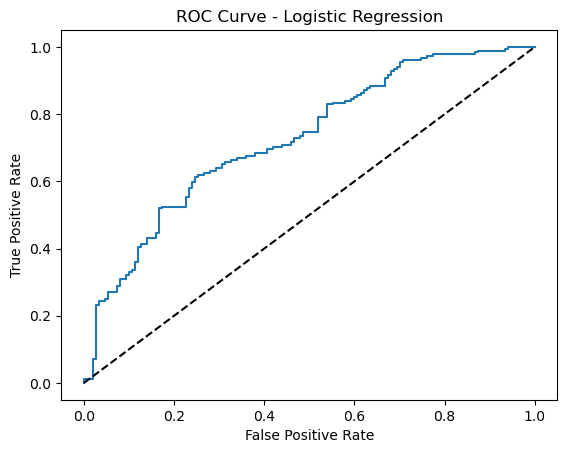

In [70]:
best_logistic.fit(movies_train_X, movies_train_Y)

from sklearn.metrics import roc_auc_score, accuracy_score

y_prob_pred = best_logistic.predict_proba(movies_test_X)[:,1]
y_pred = best_logistic.predict(movies_test_X)

print("Accuracy: ", accuracy_score(movies_test_Y, y_pred))
print("AUC: ", roc_auc_score(movies_test_Y, y_prob_pred))

#plot auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(movies_test_Y, y_prob_pred)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()

AUCPR:  0.7408234466119463


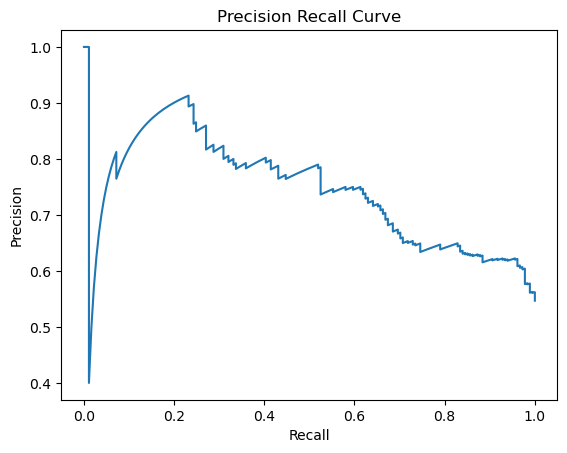

F1 Score:  0.6887755102040817


In [71]:
#calculate precision recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(movies_test_Y, y_prob_pred)

#auc of precision recall curve
from sklearn.metrics import auc

print("AUCPR: ", auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

#calculate f1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(movies_test_Y, y_pred))

In [35]:
ohe_cols = gs.best_estimator_.named_steps['transformer'].transformers_[0][1].get_feature_names_out()
imputer_cols = gs.best_estimator_.named_steps['transformer'].transformers_[1][2]
bagofw_cols = [f"genre_{i}" for i in gs.best_estimator_.named_steps['transformer'].transformers_[2][1].get_feature_names_out()]
remaining_cols = ['startYear', 'isAdult']

feature_names = np.concatenate((ohe_cols, imputer_cols, bagofw_cols, remaining_cols))


In [72]:
#create dataframe of coefficients
coef_df = pd.DataFrame(
    data=best_logistic.named_steps['logistic_regress'].coef_.T,
    index=feature_names,
    columns=['coef']
)
coef_df.sort_values(by='coef', ascending=False)

,coef
numVotes,0.205726
titleType_tvSeries,0.183452
genre_family,0.124454
genre_adventure,0.102792
genre_crime,0.088691
genre_biography,0.078875
genre_talk,0.076315
titleType_tvMiniSeries,0.052905
genre_western,0.042109
runtimeMinutes,0.034467


In [78]:
df['titleType'].value_counts()

tvSeries        1146
movie            726
tvMiniSeries     161
tvSpecial        128
short             43
tvMovie           19
tvShort            2
tvEpisode          1
Name: titleType, dtype: int64

In [76]:
df[(df['titleType']!='movie') & (df['is_tv_show']==0)]

,tconst,combined_title,release_year_x,is_top10,title,season,is_tv_show,averageRating,numVotes,titleType,isAdult,runtimeMinutes,genres
18,tt9348718,7SEEDS: Part 2,2020.0,1,7seeds: part 2,NaN,False,6.3,1462.0,tvSeries,0,25,"Action,Adventure,Animation"
20,tt13323170,800 Meters: Limited Series,2022.0,1,800 meters: limited series,NaN,False,7.0,634.0,tvMiniSeries,0,156,"Crime,Documentary"
31,tt13479662,A Go! Go! Cory Carson Christmas,2020.0,0,a go! go! cory carson christmas,NaN,False,6.1,51.0,tvSpecial,0,21,"Animation,Family,Short"
32,tt13058374,A Go! Go! Cory Carson Halloween,2020.0,0,a go! go! cory carson halloween,NaN,False,6.4,53.0,tvSpecial,0,24,"Animation,Family,Horror"
33,tt12748256,A Go! Go! Cory Carson Summer Camp,2020.0,0,a go! go! cory carson summer camp,NaN,False,5.5,36.0,tvSpecial,0,20,"Animation,Family,Short"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,tt15250050,You vs. Wild: Out Cold,2021.0,1,you vs. wild: out cold,NaN,False,5.4,339.0,short,0,25,"Adventure,Short"
2210,tt9359220,Young Wallander: Killer's Shadow,2022.0,1,young wallander: killer's shadow,NaN,False,6.9,11681.0,tvSeries,0,NaN,"Crime,Drama,Mystery"
2215,tt12055392,"Yours Sincerely, Kanan Gill",2020.0,0,"yours sincerely, kanan gill",NaN,False,7.1,986.0,tvSpecial,0,72,Comedy
2217,tt20597344,Yuri Marçal: Honest Mistake,2022.0,0,yuri marçal: honest mistake,NaN,False,6.5,46.0,tvSpecial,0,59,"Comedy,Documentary"


In [82]:
df[df['is_top10']==1]

,tconst,combined_title,release_year_x,is_top10,title,season,is_tv_show,averageRating,numVotes,titleType,isAdult,runtimeMinutes,genres
4,tt13782052,1000 Miles from Christmas,2021.0,1,1000 miles from christmas,NaN,False,5.8,1531.0,movie,0,102,"Comedy,Romance"
5,tt6275154,11M: Terror in Madrid,2022.0,1,11m: terror in madrid,NaN,False,6.9,1928.0,movie,0,92,Documentary
6,tt1837492,13 Reasons Why: Season 4,2020.0,1,13 reasons why,4,True,7.5,289852.0,tvSeries,0,60,"Drama,Mystery,Thriller"
7,tt16379224,137 Shots,2021.0,1,137 shots,NaN,False,6.3,932.0,movie,0,104,"Crime,Documentary"
9,tt14079374,14 Peaks: Nothing Is Impossible,2021.0,1,14 peaks: nothing is impossible,NaN,False,7.7,25490.0,movie,0,101,"Adventure,Documentary,Sport"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,tt8784956,Ava,2020.0,1,ava,NaN,False,5.4,55384.0,movie,0,96,"Action,Drama,Thriller"
167,tt8787802,Away: Season 1,2020.0,1,away,1,True,6.6,24116.0,tvSeries,0,50,"Drama,Romance,Sci-Fi"
170,tt7944664,B: The Beginning: Season 2 Succession,2021.0,1,b: the beginning,2 Succession,True,7.1,4995.0,tvSeries,0,25,"Action,Animation,Crime"
171,tt6357658,BAKI: The Great Raitai Tournament Saga,2020.0,1,baki: the great raitai tournament saga,NaN,False,6.7,6364.0,tvSeries,0,45,"Action,Animation,Drama"
